# EV Vehicles Registered in New York state 
<hr>

### Actions

- create function to count EV registered per zip 
- create chorophleth map of each zip with counts
- tool tips for each zipcode
- A+ - show TIME in map also 



## Import


In [3]:
# python 3.7.1

import numpy as np
import pandas as pd

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(21,9)})

# geo 
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# nan
import missingno as msno

"""

conda install folium -c conda-forge

--- 
??? branca, jinja2 and requests.
"""

'\n\nconda install folium -c conda-forge\n\n--- \n??? branca, jinja2 and requests.\n'

# Data Ingestion
<hr>

In [4]:
# looking into folders
! ls data

EV-NY-Registered_feb-2022.csv


In [5]:
df = pd.read_csv('data/EV-NY-Registered_feb-2022.csv')

In [6]:
df.shape

(663606, 9)

In [7]:
df.head(3)

,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name
0,11782,2020-10-22,JTMAB3FV,60,NY DATA.NY.GOV (1/1/2021),M,2022-10-21,NY,Toyota RAV4 Prime
1,14850,2020-10-19,JTMAB3FV,60,NY DATA.NY.GOV (1/1/2021),M,2022-10-18,NY,Toyota RAV4 Prime
2,10566,2021-11-05,JTMAB3FV,60,NY DATA.NY.GOV (1/1/2021),M,2023-12-13,NY,Toyota RAV4 Prime


In [8]:
df.tail(3)

,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name
663603,12992,2019-05-15,1FADP5CU,53,NY DATA.NY.GOV (6/1/2021),D,2021-07-17,NY,Ford C-Max Energi
663604,14617,2020-12-22,1FADP5CU,53,NY DATA.NY.GOV (6/1/2021),D,2022-12-17,NY,Ford C-Max Energi
663605,11767,2019-08-20,1FADP5CU,53,NY DATA.NY.GOV (6/1/2021),D,2021-11-04,NY,Ford C-Max Energi


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663606 entries, 0 to 663605
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   ZIP Code                      663606 non-null  int64 
 1   Registration Valid Date       663606 non-null  object
 2   VIN Prefix                    663606 non-null  object
 3   DMV ID                        663606 non-null  int64 
 4   DMV Snapshot                  663606 non-null  object
 5   VIN Model Year                663606 non-null  object
 6   Registration Expiration Date  637719 non-null  object
 7   State                         663606 non-null  object
 8   Vehicle Name                  663606 non-null  object
dtypes: int64(2), object(7)
memory usage: 45.6+ MB


<br>

# Quick EDA
<hr>

#### Unique Values per Feature

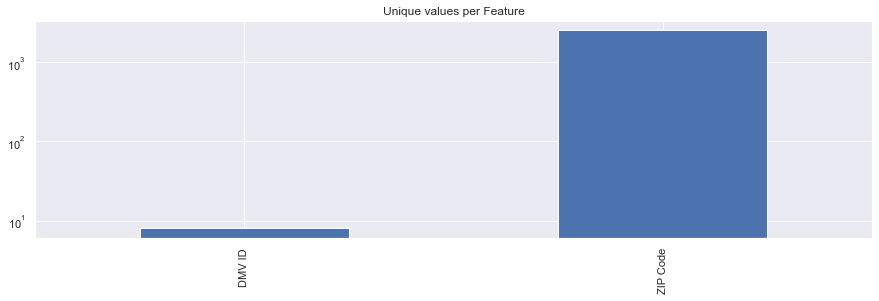

In [10]:
# See how many unique entries is in each numerical feature 
unique_values = df.select_dtypes(include= 'number').nunique().sort_values()

# Plot unique values with a y-axis in log-scale
unique_values.plot.bar(logy=True, figsize = (15,4), title='Unique values per Feature');


<br>

#### Check for Duplicates

In [11]:
 df[df.duplicated()].sort_values(by = 'ZIP Code')

,ZIP Code,Registration Valid Date,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name
415121,4263,2021-08-24,JTDKARFP,56,NY DATA.NY.GOV (9/2/2021),H,2021-09-22,NY,Toyota Prius Prime
432777,4263,2021-08-24,JTDKARFP,56,NY DATA.NY.GOV (9/2/2021),L,2021-09-22,NY,Toyota Prius Prime
418005,4263,2021-08-24,JTDKARFP,56,NY DATA.NY.GOV (9/2/2021),H,2021-09-22,NY,Toyota Prius Prime
261881,7114,2021-09-15,KM8K53AG,58,NY DATA.NY.GOV (11/1/2021),M,2022-09-30,NY,Hyundai Kona Electric
137363,7114,2021-09-16,KM8K23AG,59,NY DATA.NY.GOV (12/1/2021),M,2022-09-30,NY,Hyundai Kona Electric
...,...,...,...,...,...,...,...,...,...
550332,75261,2020-10-16,1G1RC6E4,54,NY DATA.NY.GOV (7/1/2021),B,2021-10-31,NY,Chevrolet Volt
411048,75261,2020-10-16,1G1RC6E4,56,NY DATA.NY.GOV (9/2/2021),B,2021-10-31,NY,Chevrolet Volt
44950,75261,2021-10-29,1G1RC6E4,60,NY DATA.NY.GOV (1/1/2021),B,2022-10-31,NY,Chevrolet Volt
278138,75261,2020-10-16,1G1RC6E4,57,NY DATA.NY.GOV (10/1/2021),B,2021-10-31,NY,Chevrolet Volt


In [12]:
# Check number of duplicates
n_duplicates = df.duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

#  Extract column names of all features
columns_to_consider = df.columns

# Drop duplicates based on 'columns_to_consider'
df_X = df.drop_duplicates(subset=columns_to_consider)
df_X.shape


You seem to have 23933 duplicates in your database.


(639673, 9)

In [13]:
# check duplicates
dif = set(df.index) - set(df_X.index) 


             Before removing what might be duplicates I will contact group who created the dataset

<br>

### NAN

<hr>

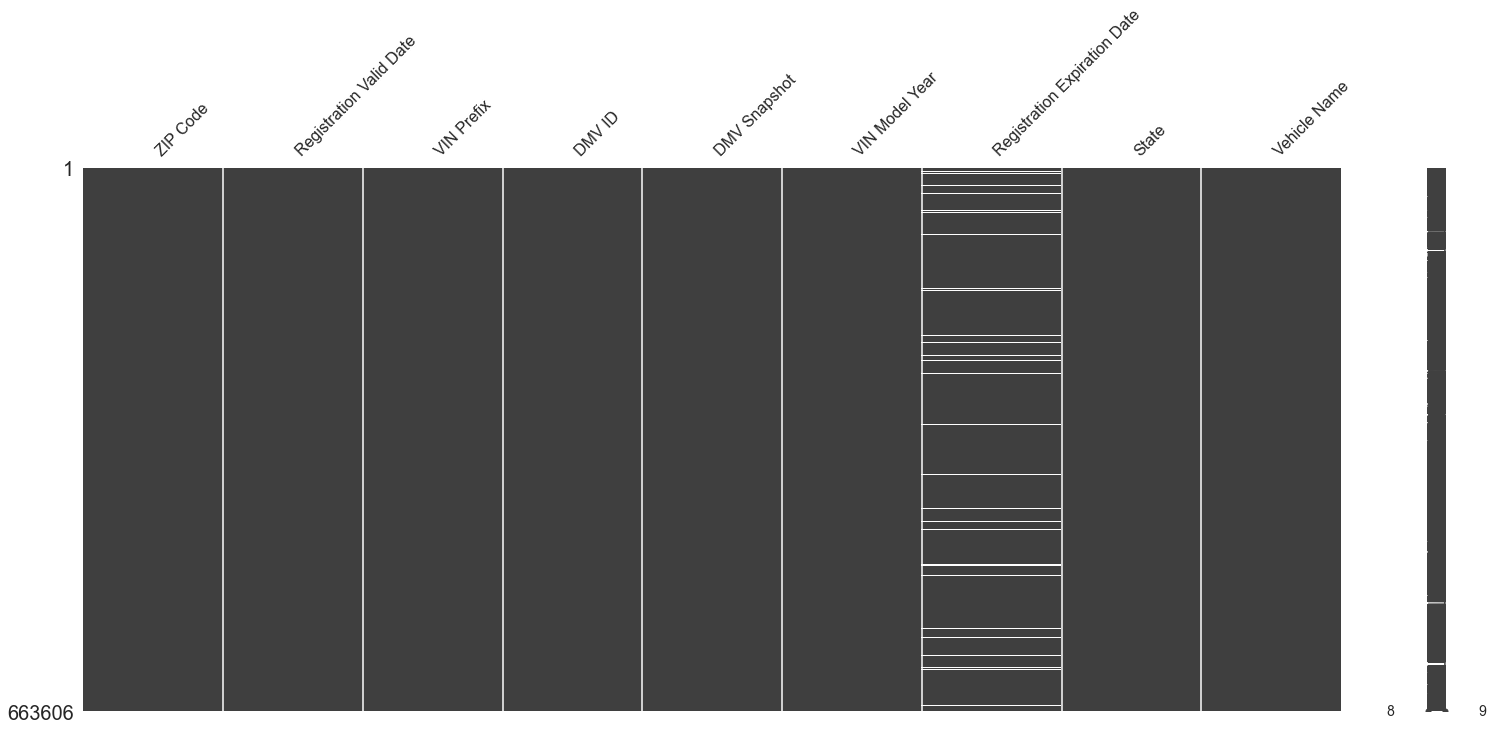

In [14]:
msno.matrix(df);

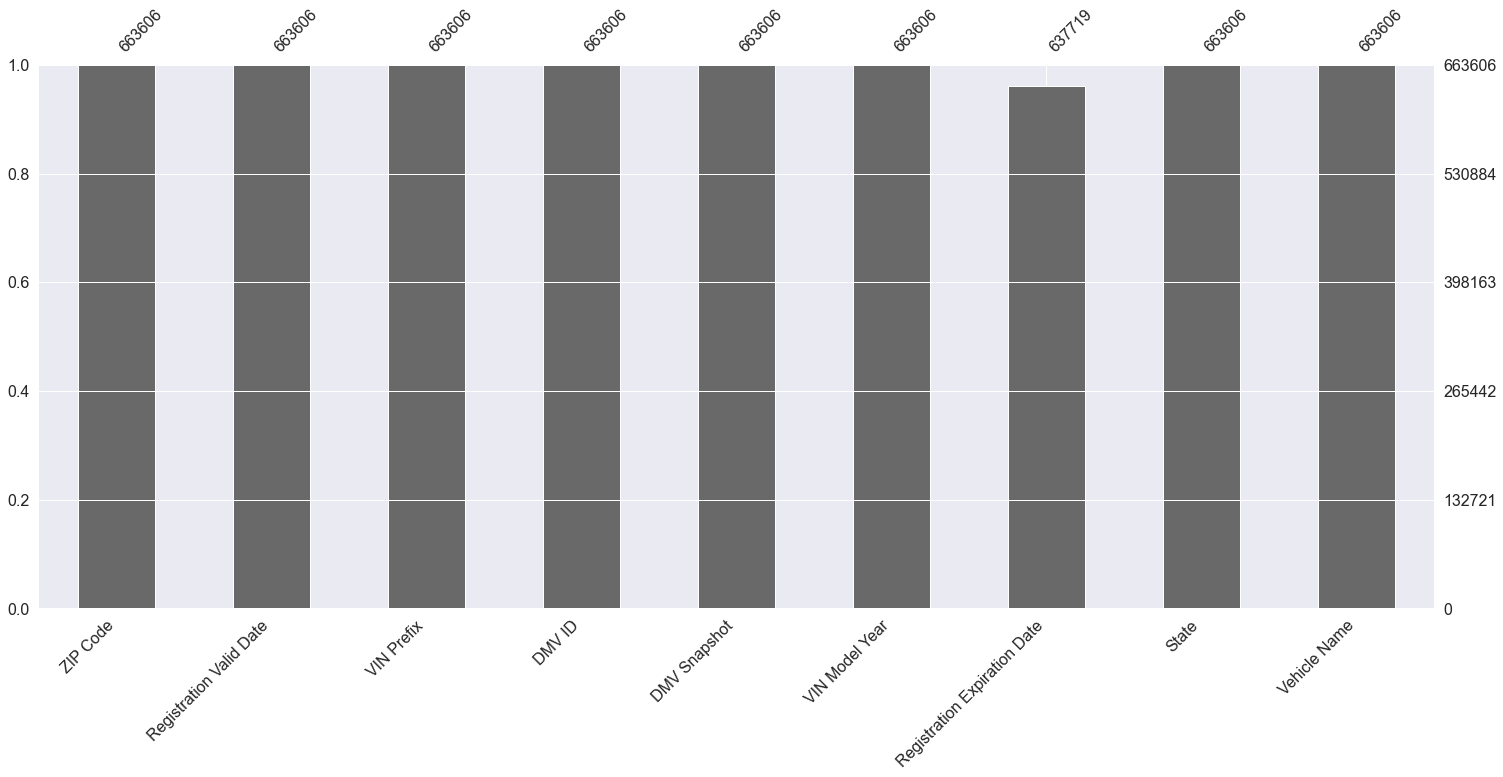

In [15]:
msno.bar(df);

<br>

#### Numerical Features

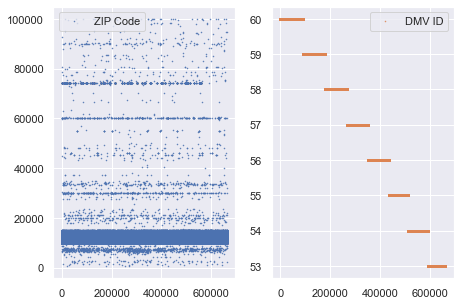

In [16]:
df.plot(lw=0,
    marker='.',
    subplots=True,
    layout=(-1,4),
    figsize=(15,5),
    markersize=1);

<br>

#### Non-Numerical Features

In [17]:
# number of non-numerical features
df.select_dtypes(exclude=["number", "datetime"]).shape

(663606, 7)

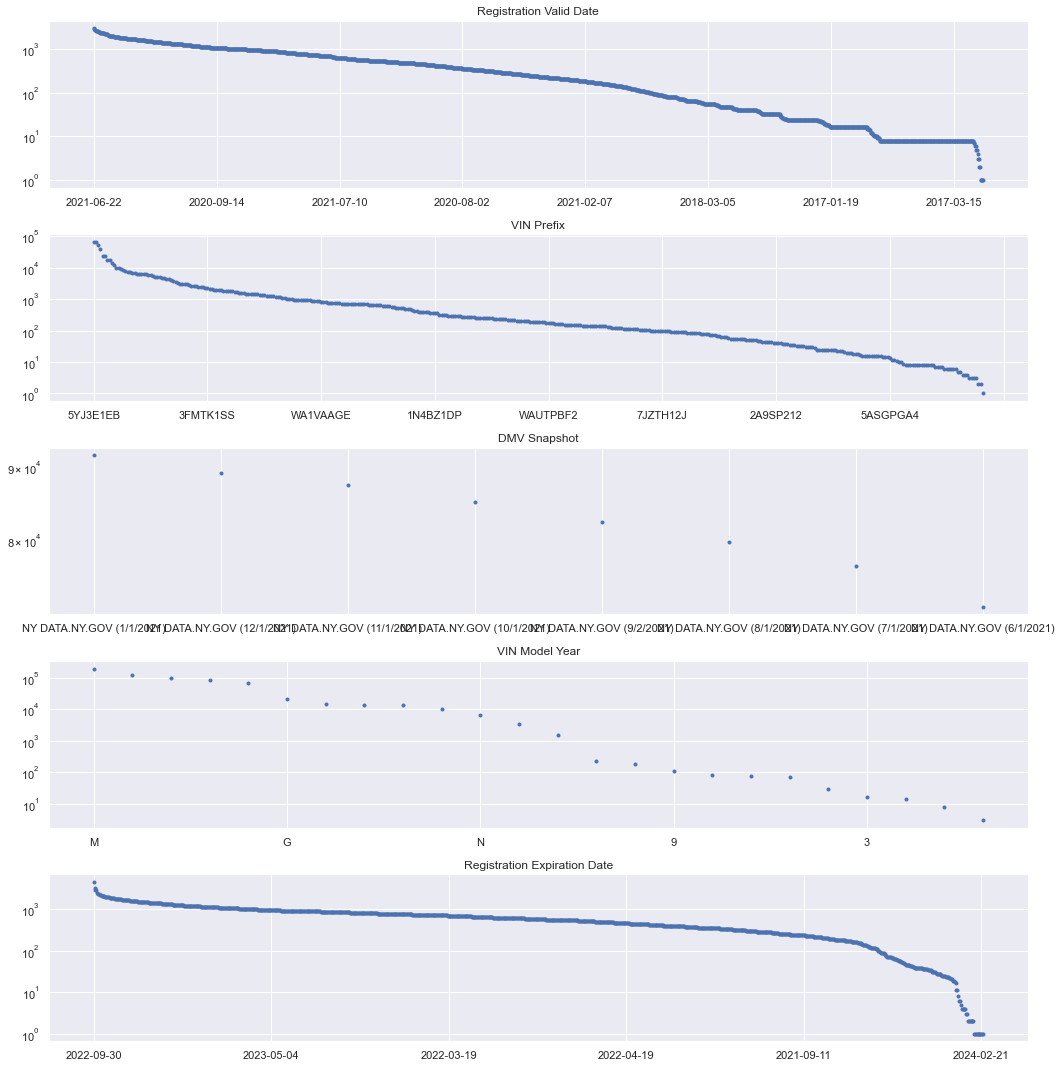

In [18]:
# Create figure object with 3 subplots
fig, axes = plt.subplots(ncols=1, nrows=5, figsize=(15, 15))

# Identify non-numerical features
df_non_numerical = df.select_dtypes(exclude=["number", "datetime"])

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Selects one single feature and counts number of unique value
    df_non_numerical[col].value_counts().plot(

        # Plots this information in a figure with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax)
    
plt.tight_layout();

<br>

#### Feature Distrobution

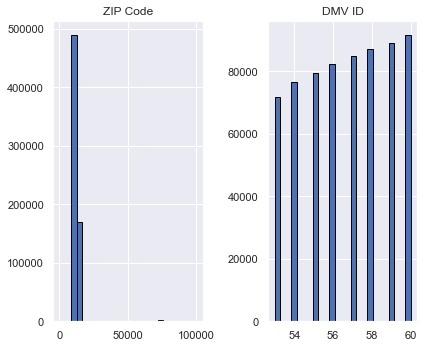

In [19]:
# Plots the histogram for each numerical feature in a separate subplot
df.hist(bins=25, figsize=(15, 5), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

# Cleaning
<hr>

In [20]:
df.columns

Index(['ZIP Code', 'Registration Valid Date', 'VIN Prefix', 'DMV ID',
       'DMV Snapshot', 'VIN Model Year', 'Registration Expiration Date',
       'State', 'Vehicle Name'],
      dtype='object')

# Feature Creation
<hr>

In [21]:
df['Registration Valid Date'] = pd.to_datetime(df['Registration Valid Date'])

In [22]:
# create features of Date
df['month'] = df['Registration Valid Date'].dt.month
df['year'] = df['Registration Valid Date'].dt.year

In [23]:
df.set_index('Registration Valid Date', inplace=True)
df.sort_index(inplace = True)

<br>

## Functions
<hr>

In [24]:
"""
Function to create count per zip code 

"""

'\nFunction to create count per zip code \n\n'

<br>

# Exploration
<hr>

In [25]:
df.loc['2016']

,ZIP Code,VIN Prefix,DMV ID,DMV Snapshot,VIN Model Year,Registration Expiration Date,State,Vehicle Name,month,year
Registration Valid Date,,,,,,,,,,
2016-01-08,11368,3FA6P0PU,58,NY DATA.NY.GOV (11/1/2021),G,NaN,NY,Ford Fusion Energi,1,2016
2016-01-08,11368,3FA6P0PU,55,NY DATA.NY.GOV (8/1/2021),G,NaN,NY,Ford Fusion Energi,1,2016
2016-01-08,11368,3FA6P0PU,60,NY DATA.NY.GOV (1/1/2021),G,NaN,NY,Ford Fusion Energi,1,2016
2016-01-08,11368,3FA6P0PU,54,NY DATA.NY.GOV (7/1/2021),G,NaN,NY,Ford Fusion Energi,1,2016
2016-01-08,11368,3FA6P0PU,53,NY DATA.NY.GOV (6/1/2021),G,NaN,NY,Ford Fusion Energi,1,2016
...,...,...,...,...,...,...,...,...,...,...
2016-12-30,10601,1FADP3R4,53,NY DATA.NY.GOV (6/1/2021),G,NaN,NY,Ford Focus EV,12,2016
2016-12-30,10601,1FADP3R4,53,NY DATA.NY.GOV (6/1/2021),G,NaN,NY,Ford Focus EV,12,2016
2016-12-30,10601,1FADP3R4,58,NY DATA.NY.GOV (11/1/2021),G,NaN,NY,Ford Focus EV,12,2016


In [26]:
df.head(1).T

Registration Valid Date,2014-04-10
ZIP Code,12238
VIN Prefix,JTDKN3DP
DMV ID,55
DMV Snapshot,NY DATA.NY.GOV (8/1/2021)
VIN Model Year,C
Registration Expiration Date,NaN
State,NY
Vehicle Name,Toyota Prius Plug-in
month,4
year,2014


In [95]:
# number of EV cars registered per year in NY state

df_counts = df.groupby(['year']).size().reset_index(name='counts')
df_counts['percent'] = round((df_counts['counts'] / df_counts['counts'].sum()) * 100,2)
df_counts

,year,counts,percent
0,2014,2115,0.32
1,2015,940,0.14
2,2016,2165,0.33
3,2017,3618,0.55
4,2018,6170,0.93
5,2019,46545,7.01
6,2020,248666,37.47
7,2021,353362,53.25
8,2022,25,0.00


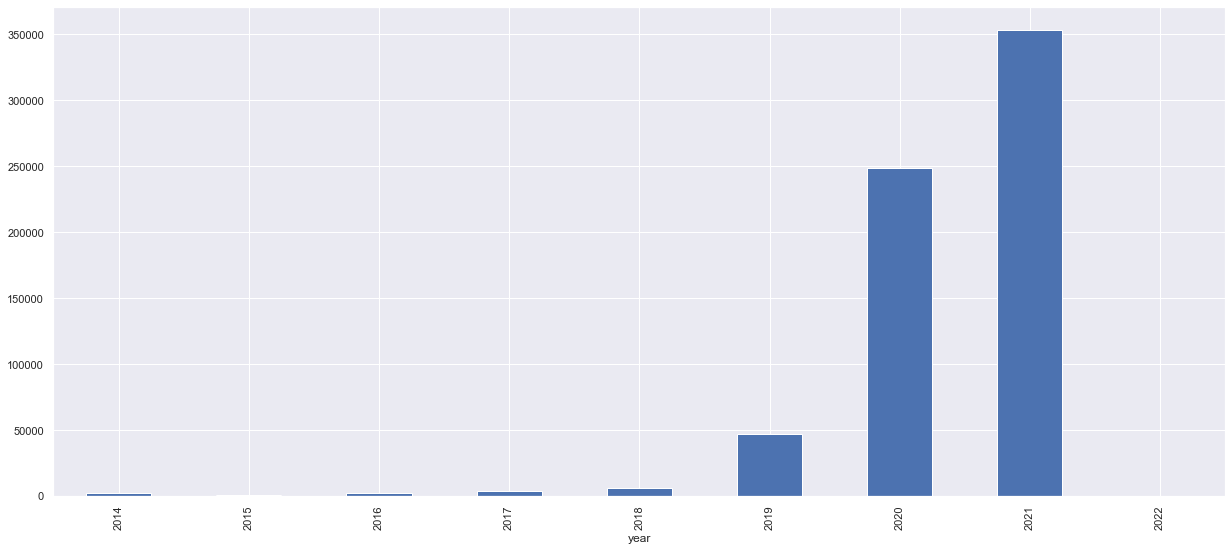

In [99]:
# number of EV Cars registed per year in NYS
df.groupby('year').size().plot(kind = "bar");

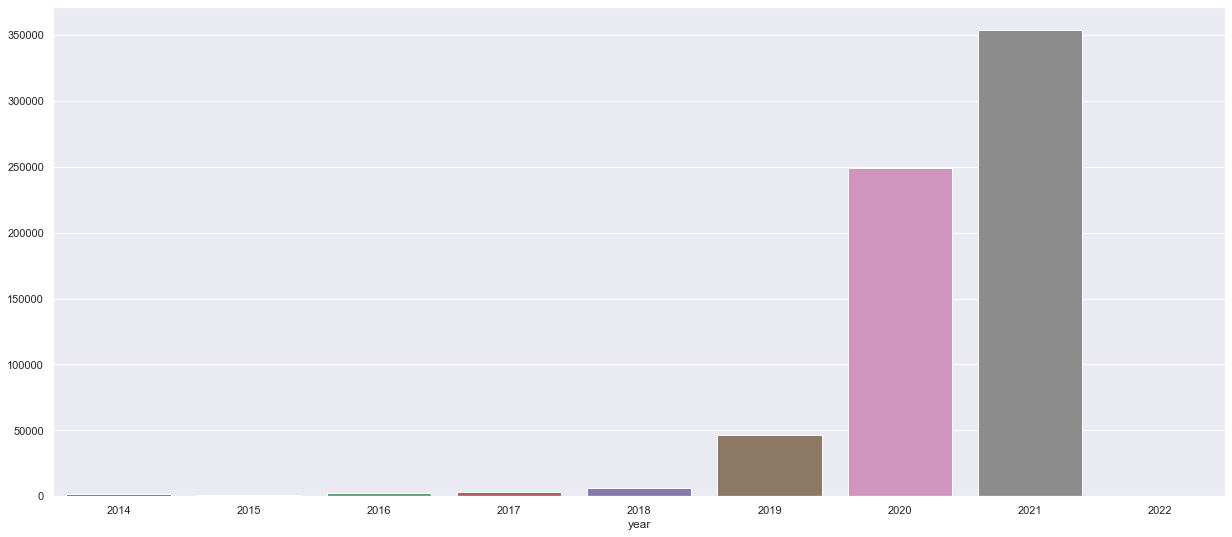

In [100]:
# number of EV Cars registed per year in NYS
result = df.groupby('year').size()
sns.barplot(x = result.index, y = result.values);

AttributeError: 'float' object has no attribute 'sum'

In [76]:
# NUmber of EV cars registered 
df.groupby(['year','ZIP Code',]).size().reset_index(name='counts')

,year,ZIP Code,counts
0,2014,10004,16
1,2014,10007,4
2,2014,10014,8
3,2014,10035,587
4,2014,10038,16
...,...,...,...
5403,2022,13825,1
5404,2022,14127,1
5405,2022,14223,1
5406,2022,14580,1


<br> 

#### Zip Code

In [27]:
# number of unique zip codes
df['ZIP Code'].nunique()

2525

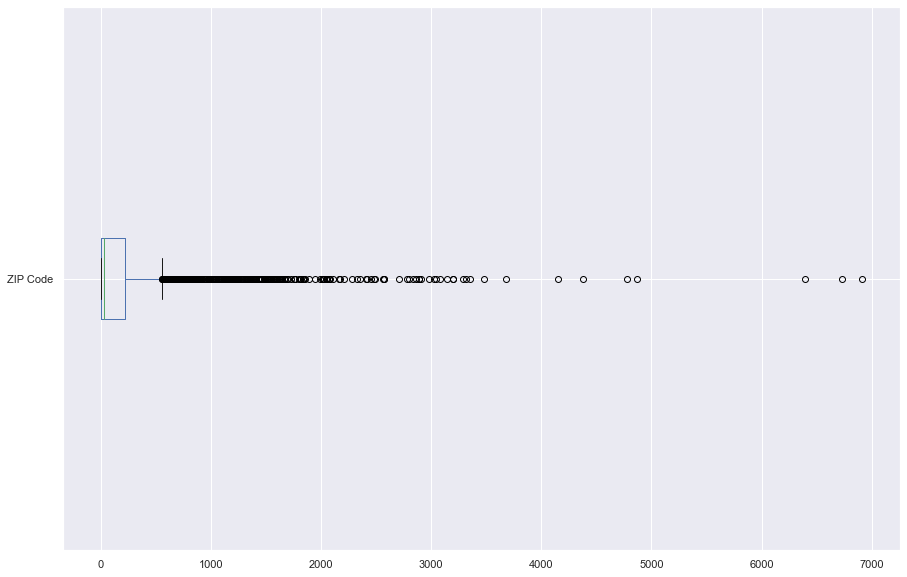

In [29]:
df['ZIP Code'].value_counts().plot(kind = 'box', vert=False, figsize=(15,10));

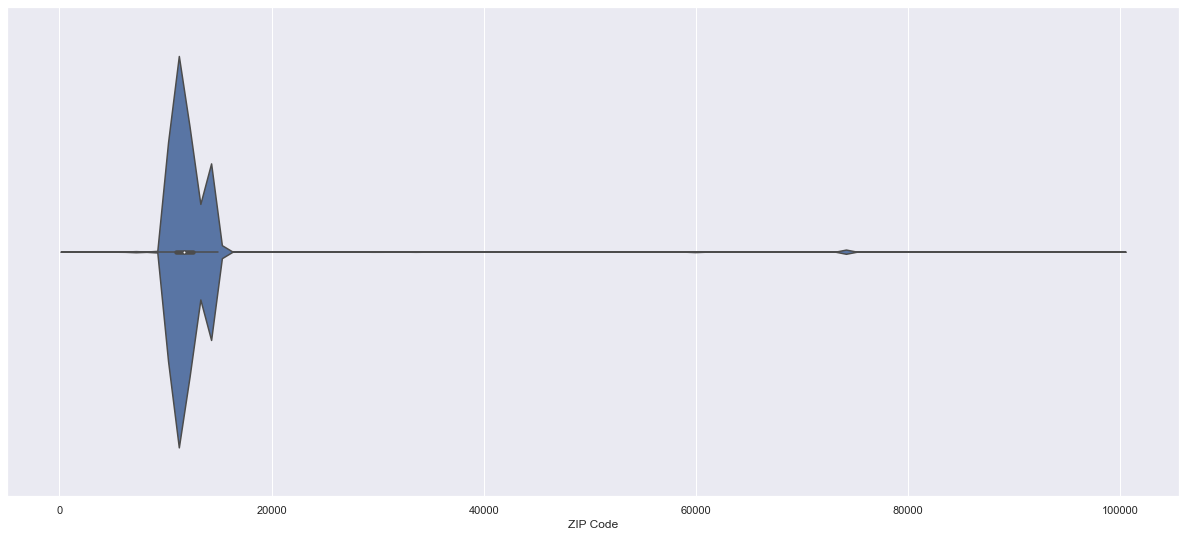

In [30]:
sns.violinplot(x=df['ZIP Code']);

In [31]:
"""
Create folium map of for zip codes
     data count per area

"""

'\nCreate folium map of for zip codes\n     data count per area\n\n'

<br>

#### VIN Prefix

In [32]:
df['VIN Prefix'].nunique()

392

In [33]:
# top 10 VIN prefix
df['VIN Prefix'].value_counts().sort_values(ascending=False).head(10)

5YJ3E1EB    67293
JTDKARFP    64876
5YJYGDEE    55050
5YJ3E1EA    40282
5YJSA1E2    23504
JTDKAMFP    23467
3FA6P0SU    17692
JTMAB3FV    17500
JTDKN3DP    14293
1G1RC6S5    12103
Name: VIN Prefix, dtype: int64

#### VIN Model Year

In [34]:
df['VIN Model Year'].unique()

array(['C', 'E', 'A', '8', 'D', 'B', 'F', '9', '5', '2', 'G', 'H', 'J',
       '6', 'K', '7', 'L', '1', 'S', '3', 'X', 'M', 'N', 'Y'],
      dtype=object)

In [35]:
# top 10 VIN Model Year
df['VIN Model Year'].value_counts().head(10)

M    196660
L    124935
J    101440
K     88179
H     66097
G     21366
F     14327
D     14004
E     13924
C     10490
Name: VIN Model Year, dtype: int64

#### DMV Snapshot

In [36]:
df['DMV Snapshot'].unique()

array(['NY DATA.NY.GOV (8/1/2021)', 'NY DATA.NY.GOV (10/1/2021)',
       'NY DATA.NY.GOV (1/1/2021)', 'NY DATA.NY.GOV (9/2/2021)',
       'NY DATA.NY.GOV (7/1/2021)', 'NY DATA.NY.GOV (11/1/2021)',
       'NY DATA.NY.GOV (12/1/2021)', 'NY DATA.NY.GOV (6/1/2021)'],
      dtype=object)

#### DMV ID

In [37]:
df['DMV ID'].unique()

array([55, 57, 60, 56, 54, 58, 59, 53])

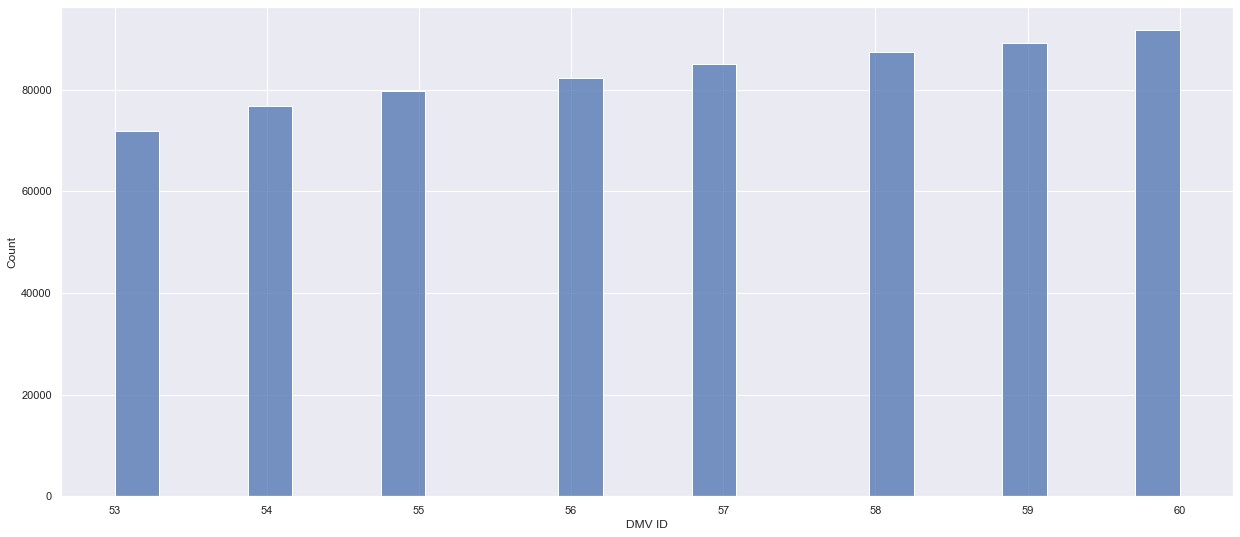

In [38]:
sns.histplot( data = df['DMV ID'], bins = 24);

##### State

In [39]:
df['State'].unique()

array(['NY'], dtype=object)